# Notebook to plot GPS timeseries for Mauna Loa volcano


In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.cm as cm
import datetime
import pandas as pd
import matplotlib.dates as mdates
import time
from datetime import datetime as dt
from dateutil.relativedelta import relativedelta
from IPython.core.debugger import set_trace

## Functions to read GPS data from file and reference it to 'MKEA' station

In [2]:
def read_ref_data(time1,time2):
    filename='./data/'+'MKEA.txt'
    dfin = pd.read_csv(filename, header=0, delimiter=r"\s+")
    index = ['Time', 'East', 'North', 'Up']
    dataval=pd.DataFrame(index=index)
    dataerr=pd.DataFrame(index=index);
    dataval=pd.concat([dfin['YYMMMDD'].rename('date'), (dfin['_e0(m)']+dfin['__east(m)']).rename('east'), (dfin['____n0(m)']+dfin['_north(m)']).rename('north'), 
                       (dfin['u0(m)']+dfin['____up(m)']).rename('up'),dfin['yyyy.yyyy'].rename('dateval')], axis=1)
    dataerr=pd.concat([dfin['YYMMMDD'].rename('date'), 
                       dfin['sig_e(m)'], dfin['sig_n(m)'], dfin['sig_u(m)']], axis=1,ignore_index=False)
    dataval['date']=pd.to_datetime(dataval['date'], format='%y%b%d', errors='ignore')
    dataerr['date']=pd.to_datetime(dataval['date'], format='%y%b%d', errors='ignore')
    time1 = pd.to_datetime(time1)
    time2 = pd.to_datetime(time2)
    mask= (dataval['date'] > time1) & (dataval['date'] < time2)
    dataval=dataval[mask];
    dataerr=dataerr[mask];
    dataval=dataval.set_index(['date'])
    dataval=dataval.resample('D').interpolate(method='linear')
    dataval=dataval.reset_index()
    return dataval

def read_data(sitename,time1,time2):
    filename='./data/'+sitename+'.txt'
    dfin = pd.read_csv(filename, header=0, delimiter=r"\s+")
    index = ['Time', 'East', 'North', 'Up']

    dataval=pd.DataFrame(index=index);dataerr=pd.DataFrame(index=index);
    dataval=pd.concat([dfin['YYMMMDD'].rename('date'), (dfin['_e0(m)']+dfin['__east(m)']).rename('east'), (dfin['____n0(m)']+dfin['_north(m)']).rename('north'), 
                       (dfin['u0(m)']+dfin['____up(m)']).rename('up'),dfin['yyyy.yyyy'].rename('dateval')], axis=1)
    dataerr=pd.concat([dfin['YYMMMDD'].rename('date'), dfin['sig_e(m)'], dfin['sig_n(m)'], dfin['sig_u(m)']], axis=1,ignore_index=False)
    dataval['date']=pd.to_datetime(dataval['date'], format='%y%b%d', errors='ignore')
    dataerr['date']=pd.to_datetime(dataval['date'], format='%y%b%d', errors='ignore')
    time1 = pd.to_datetime(time1)
    time2 = pd.to_datetime(time2)
    mask= (dataval['date'] > time1) & (dataval['date'] < time2)
    dataval=dataval[mask];dataerr=dataerr[mask];
    #reference to MKEA
    dataval2=read_ref_data(time1,time2)
    merged=pd.merge(dataval,dataval2,how='inner',on=['date'])
    merged['east']=merged['east_x']-merged['east_y'];
    merged['north']=merged['north_x']-merged['north_y'];
    merged['up']=merged['up_x']-merged['up_y'];
    merged['dateval']=(merged['dateval_x']+merged['dateval_y'])*0.5
    merged=merged[['date','east','north','up','dateval']]
    return merged


## Plot figure

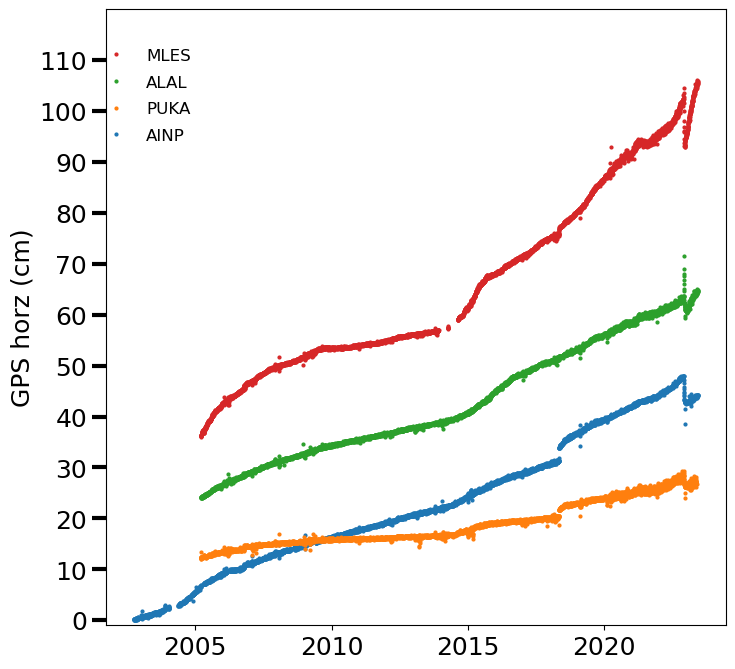

In [3]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 8), gridspec_kw = {'height_ratios':[1.5]});

#customize axes
fig.subplots_adjust(hspace=0.05)
ff=18;ffti=18;

axes.tick_params(labelsize=ff);
axes.tick_params(axis='y',length=10, width=3);
axes.tick_params(which='minor',length=0, width=0);
axes.set_yticks([0,10,20]);axes.set_yticks([0,10,20,30,40,50,60,70,80,90,100,110]);

#############################################################
#############################################################
#############################################################
x=[datetime.date(2002, 1, 21), datetime.date(2023, 6, 30)];  horz_max=120; up_max=31; h_step=12
# x=[datetime.date(2022, 12, 6), datetime.date(2023, 6, 30)]; horz_max=25; up_max=31; h_step = 3
# x=[datetime.date(2022, 11, 27), datetime.date(2023, 6, 30)]; horz_max=25; up_max=31; h_step = 3
# #x=[datetime.date(2018, 9, 1), datetime.date(2022, 11, 26)]; horz_max=31; up_max=31; h_step = 3
# #x=[datetime.date(2022, 11, 25), datetime.date(2022, 12, 10)]; horz_max=200; up_max=31; h_step = 20


# Stations with missing 2023 data: MLSP, PAT3 in east, STEP, MOKP in west
site_list=['AINP','PUKA','ALAL','MLES']; # Eastern Flank
# site_list=['YEEP','BLBP','STEP','SLPC','TOUO','ALEP','PHAN','MOKP']; # Western Flank
# site_list=['SLPC','TOUO','ALEP','PHAN','MOKP']; # Western Flank

what_to_plot = 'up'
what_to_plot = 'horz'
#############################################################
#############################################################
#############################################################

if what_to_plot is 'up':
    ylim = [-3,up_max]
if what_to_plot is 'horz':
    ylim = [-1,horz_max]  

duration = relativedelta(x[1], x[0])
duration_years = duration.years + duration.months / 12 + duration.days / 365

marker_size= 2.0
if duration_years > 2:
    axes.xaxis.set_major_locator(mdates.YearLocator(base=1))
    if duration_years > 5:
        axes.xaxis.set_major_locator(mdates.YearLocator(base=5))
else:
    marker_size= 5.0
    loc_years = mdates.YearLocator(1)   # every year
    loc_month = mdates.MonthLocator(interval=1)  # every second month
    fmt_years = mdates.DateFormatter('%b-%y') 
    # axes.xaxis.set_major_locator(loc_month)
    axes.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    axes.xaxis.set_major_formatter(fmt_years)


    #plot GPS timeseries
#############################################################
#############################################################
time1=x[0];time2=x[1];h=0; u=0
for site in site_list:
    gps_data=read_data(site,time1,time2);
    gps_data['up']=(gps_data['up']-gps_data['up'].iloc[0:10].mean())*100+u; u=u+4;
    gps_data['north']=(gps_data['north']-gps_data['north'].iloc[0:10].mean())*100 #+t;t=t+15;
    gps_data['east']=(gps_data['east']-gps_data['east'].iloc[0:10].mean())*100 #+t; #t=t+15;
    gps_data['horz']=(gps_data['east']*gps_data['east']+gps_data['north']*gps_data['north'])**(0.5)+h; h=h+h_step;
    axes.plot_date(gps_data['date'],gps_data[what_to_plot],marker='o',markersize=marker_size,label=site);
axes.set_ylabel('GPS ' + what_to_plot + ' (cm)',fontsize=ffti);

plt.ylim(ylim)
# plt.xlim(xlim)
lgnd=axes.legend(labelspacing=-2.5,fontsize=12,bbox_to_anchor=(0.25, 0.75), bbox_transform=plt.gcf().transFigure,frameon=False)
#save plot
#plt.savefig('Fig.1c-f_displacement_over_SeismicityRates.pdf',dpi=300,bbox_inches='tight',transparent=True)


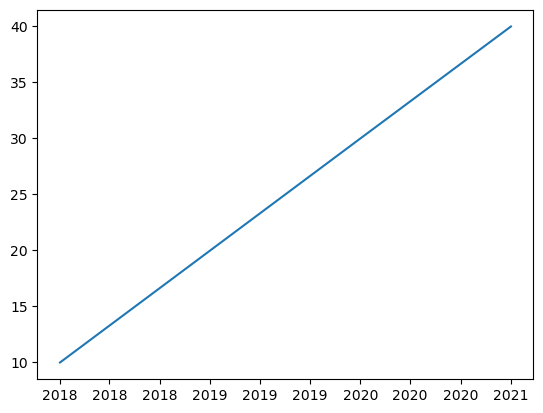

In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime

# Generate some sample data
dates = [datetime.datetime(2018, 1, 1), datetime.datetime(2019, 1, 1), datetime.datetime(2020, 1, 1), datetime.datetime(2021, 1, 1)]
values = [10, 20, 30, 40]

# Create the plot
plt.plot(dates, values)

# Set the x-axis tick label format to show the year as a whole number
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Show the plot
plt.show()

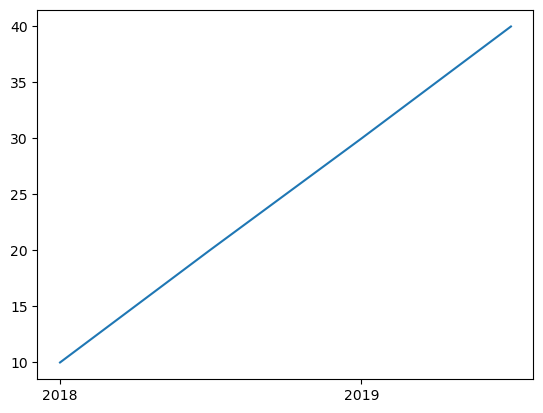

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime

# Generate some sample data
dates = [datetime.datetime(2018, 1, 1), datetime.datetime(2018, 7, 1), datetime.datetime(2019, 1, 1), datetime.datetime(2019, 7, 1)]
values = [10, 20, 30, 40]

# Create the plot
plt.plot(dates, values)

# Set the x-axis tick locator to show major ticks at yearly intervals
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=1))

# Set the x-axis tick label format to show only the year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Show the plot
plt.show()